# **Technical Answers for Real World Problems** (TARP)
# **WHEAT DISEASE CLASSIFICATION**

# Importing important Libraries


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from keras.optimizers import Adam
from PIL import Image
from sklearn.metrics import classification_report
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications import VGG19
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle
from keras.models import Model
from glob import glob


## Connecting to Gdrive & importing dataset

In [11]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [12]:
dataset = "/gdrive/My Drive/Tarp Dataset/"
label = "lb.pickle"

### Inputting the folders name as labels

In [13]:
LABELS = set(["Crown and Root Rot","Healthy Wheat", "Leaf Rust", "Loose Smut"])

In [14]:
imagePaths = list(paths.list_images(dataset))
print(imagePaths)
data = []
labels = []

['/gdrive/My Drive/Tarp Dataset/Healthy Wheat/12791.jpg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/12801.jpg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/06851.jpg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/09251.jpg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/01631.jpeg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/05691.jpg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/07241.jpg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/07841.jpeg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/05241.jpg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/02051.jpg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/01601.jpeg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/01791.jpg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/03841.jpg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/02191.jpg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/02431.jpg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/07811.jpeg', '/gdrive/My Drive/Tarp Dataset/Healthy Wheat/03281.jpg', '/gdrive/My Drive/Tarp Dat

In [15]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    if label not in LABELS:
        continue
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    labels.append(label)


In [16]:
data = np.array(data)
labels = np.array(labels)

if labels.size > 0:
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
else:
    print("Error: Labels array is empty or contains no samples.")

# Data Augumentation

In [17]:
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [18]:
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

## Spiltting the dataset

In [19]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.30, stratify=labels, random_state=42)

In [20]:
trainX.shape

(2342, 224, 224, 3)

In [21]:
testX.shape

(1005, 224, 224, 3)

In [22]:
trainY.shape

(2342, 4)

In [23]:
testY.shape

(1005, 4)

# **Model Building**

In [24]:
headmodel = VGG19(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

80134624/80134624 [==============================] - 0s 0us/step


In [25]:
model = headmodel.output
model = AveragePooling2D(pool_size=(5, 5))(model)
model = Flatten(name="flatten")(model)
model = Dense(512, activation="relu")(model)
model = Dropout(0.4)(model)
model = Dense(len(lb.classes_), activation="softmax")(model)
moodel = Model(inputs=headmodel.input, outputs=model)

In [26]:
for layer in headmodel.layers:
    layer.trainable = False

In [27]:
moodel.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])

In [28]:
H = moodel.fit(
    trainAug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=len(trainX) // 64,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 64,
    epochs=50)

Epoch 1/50
36/36 [==============================] - 56s 1s/step - loss: 2.5244 - accuracy: 0.5386 - val_loss: 1.1041 - val_accuracy: 0.7292
Epoch 2/50
36/36 [==============================] - 34s 936ms/step - loss: 1.1618 - accuracy: 0.6651 - val_loss: 0.7577 - val_accuracy: 0.7542
Epoch 3/50
36/36 [==============================] - 34s 952ms/step - loss: 0.7712 - accuracy: 0.7191 - val_loss: 0.6464 - val_accuracy: 0.7708
Epoch 4/50
36/36 [==============================] - 34s 935ms/step - loss: 0.6694 - accuracy: 0.7463 - val_loss: 0.6321 - val_accuracy: 0.7979
Epoch 5/50
36/36 [==============================] - 35s 977ms/step - loss: 0.5986 - accuracy: 0.7748 - val_loss: 0.5556 - val_accuracy: 0.8167
Epoch 6/50
36/36 [==============================] - 34s 950ms/step - loss: 0.5666 - accuracy: 0.7761 - val_loss: 0.6072 - val_accuracy: 0.7958
Epoch 7/50
36/36 [==============================] - 35s 956ms/step - loss: 0.5252 - accuracy: 0.7989 - val_loss: 0.5244 - val_accuracy: 0.8125
Ep

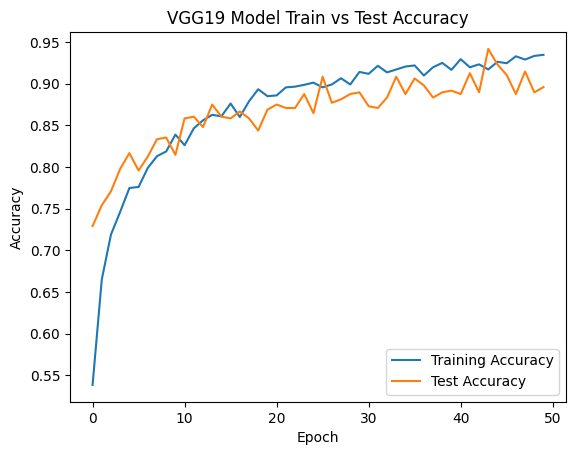

<Figure size 640x480 with 0 Axes>

In [29]:
N = 50
plt.plot(np.arange(0, N), H.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(0, N), H.history['val_accuracy'], label="Test Accuracy")
plt.title('VGG19 Model Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
plt.savefig("acc_plot.png")


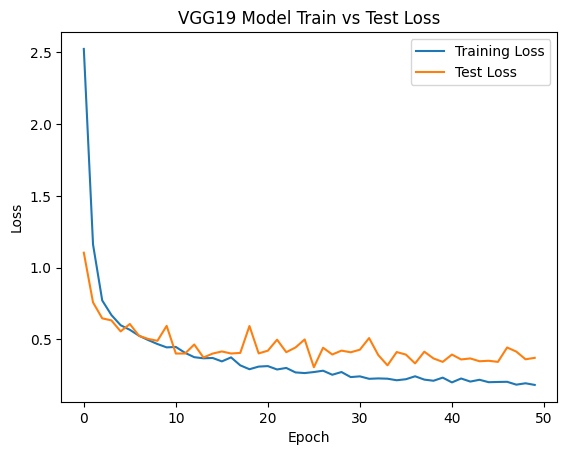

<Figure size 640x480 with 0 Axes>

In [30]:
plt.plot(H.history['loss'], label="Training Loss")
plt.plot(H.history['val_loss'], label="Test Loss")
plt.title('VGG19 Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
plt.savefig("loss_plot.png")


In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Generating predictions on test data
predictions = moodel.predict(testX, batch_size=64)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(testY, axis=1)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Printing confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Generating classification report
class_report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(class_report)


16/16 [==============================] - 11s 751ms/step
Confusion Matrix:
[[285  10   0  12]
 [  9 323   1  11]
 [  2   4  67   2]
 [ 14  19   8 238]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       307
           1       0.91      0.94      0.92       344
           2       0.88      0.89      0.89        75
           3       0.90      0.85      0.88       279

    accuracy                           0.91      1005
   macro avg       0.90      0.90      0.90      1005
weighted avg       0.91      0.91      0.91      1005



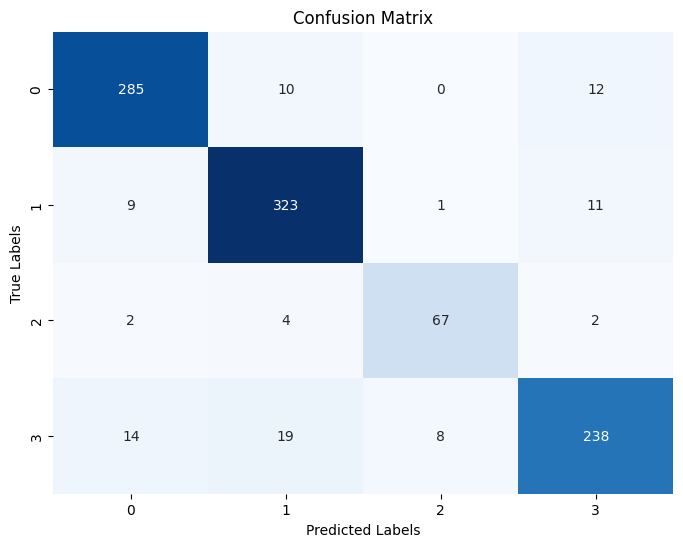

In [32]:
# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# KFold Cross-Validation

In [36]:
import tensorflow as tf
from tensorflow.keras.models import clone_model
import tensorflow as tf
from sklearn.model_selection import KFold

In [37]:
moodel = tf.keras.models.load_model('model.h5')
kf = KFold(n_splits=2, shuffle=True)
cv_scores = []

for train_index, test_index in kf.split(trainX, trainY):


    model = tf.keras.Sequential()
    model.add(headmodel)
    model.add(AveragePooling2D(pool_size=(5, 5)))
    model.add(Flatten(name="flatten"))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.4))
    model.add(Dense(len(lb.classes_), activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])
    model.fit(trainAug.flow(trainX[train_index], trainY[train_index], batch_size=64),
              steps_per_epoch=len(trainX[train_index]) // 64,
              epochs=30)

    test_loss, test_acc = model.evaluate(valAug.flow(trainX[test_index], trainY[test_index]))
    cv_scores.append(test_acc)
print('Average cross-validation score:', np.mean(cv_scores))


Epoch 1/30
18/18 [==============================] - 17s 894ms/step - loss: 3.0792 - accuracy: 0.4806
Epoch 2/30
18/18 [==============================] - 16s 875ms/step - loss: 1.6782 - accuracy: 0.6450
Epoch 3/30
18/18 [==============================] - 16s 919ms/step - loss: 1.0986 - accuracy: 0.6947
Epoch 4/30
18/18 [==============================] - 15s 851ms/step - loss: 1.0156 - accuracy: 0.7001
Epoch 5/30
18/18 [==============================] - 15s 840ms/step - loss: 0.8050 - accuracy: 0.7344
Epoch 6/30
18/18 [==============================] - 15s 842ms/step - loss: 0.6789 - accuracy: 0.7543
Epoch 7/30
18/18 [==============================] - 15s 850ms/step - loss: 0.5987 - accuracy: 0.7850
Epoch 8/30
18/18 [==============================] - 15s 834ms/step - loss: 0.5636 - accuracy: 0.7931
Epoch 9/30
18/18 [==============================] - 15s 848ms/step - loss: 0.5840 - accuracy: 0.7812
Epoch 10/30
18/18 [==============================] - 16s 845ms/step - loss: 0.5197 - accura

In [33]:
# saving the model to disk
moodel.save("model.h5")
f = open("label", "wb")
f.write(pickle.dumps(lb))
f.close()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Testing**

In [34]:
from keras.models import load_model
import imutils
import cv2
from google.colab.patches import cv2_imshow
from keras.models import load_model
from collections import deque
import pickle

In [35]:
import cv2
import pickle
import numpy as np
from collections import deque
from tensorflow.keras.models import load_model

model_path = "/content/model.h5"
input_path = "/content/00411.jpg"
label_file = "lb.pickle"

moodel = load_model(model_path)
lb = pickle.loads(open("label", "rb").read())

mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)
vs = cv2.VideoCapture(input_path)

(W, H) = (None, None)

while True:
    (grabbed, frame) = vs.read()

    if not grabbed:
        break

    if W is None or H is None:
        (H, W) = frame.shape[:2]

    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean

    preds = moodel.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(preds)

    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = lb.classes_[i]

    text = "PREDICTION: {}".format(label.upper())


     # Put prediction text below the input image
    text_x = int(W / 2 - len(text) * 6)
    text_y = int(H * 1.1)

    # Draw a rectangle behind the text for better visibility
    cv2.rectangle(output, (0, text_y - 25), (W, text_y + 10), (0, 0, 0), -1)
    cv2.putText(output, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX,
                0.6, (200, 255, 155), 2)

    cv2_imshow(output)
    print(text)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break

vs.release()
cv2.destroyAllWindows()
